# Analysis of the Impact of Dithering on Image Classifiability with Convolutional Neural Networks (CNN)

In this project we will analyze how **quantization** and different **dithering** techniques affect the ability of a **convolutional neural network (CNN)** to correctly classify realistic images.

We will use a subset of the **Caltech 256** dataset, consisting of **5 object classes**, each with 100 images.

The reduction in color depth (e.g., from 8 bits to 2 bits per channel) degrades the visual quality of images, making the classification task more difficult.  
To mitigate this effect, **dithering** techniques can be applied, which simulate lost gradations by distributing the visual error to neighboring pixels.

## Approach used
We will train a **convolutional neural network (CNN)** on original images and test it to establish a benchmark. Subsequently, we will also test the model on **quantized** and **dithered** versions of the images.

Finally, we will evaluate whether dithering improves not only human visual perception, but also **automatic classification** by the model.

## Notebook structure
- Loading and preprocessing the dataset
- Defining the CNN and training on original images
- Applying degradation techniques (quantization and dithering)
- Evaluating performance on original and degraded images
- Analysis and comparison of results

# 1. Project Initialization

In this phase we import the main libraries that we will use for loading, manipulating images and building the convolutional neural network (CNN).

We also define the dataset and the dimension to which to resize all images (e.g., 128x128 pixels), so that they can be processed uniformly.

In [40]:
# 1. Import main libraries

import os                                               # To manage files and folders
import numpy as np                                      # For numerical and matrix operations
import matplotlib.pyplot as plt                         # To display images
from sklearn.model_selection import train_test_split    # To split the dataset into training and test
from sklearn.metrics import accuracy_score              # To calculate model accuracy
from sklearn.metrics import confusion_matrix            # To calculate the confusion matrix
import seaborn as sns                                   # To visualize the confusion matrix


from tensorflow.keras.preprocessing.image import load_img, img_to_array             # To load and preprocess images
from tensorflow.keras.models import Sequential                                      # To build the neural network model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout   # To add layers to the neural network
from tensorflow.keras.optimizers import Adam                                        # To optimize the model
from tensorflow.keras.callbacks import EarlyStopping                                # To stop training early if there are no improvements

# Path to the folder containing the 5 subfolders (classes)
dataset_path = "Dataset"

# Target size for image resizing
img_size = (128, 128)


import random               # To generate random numbers
import tensorflow as tf     # To build and train the neural network model

# Setting the seed for reproducibility of results
seed = 2
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# 2. Loading and Preprocessing Images

In this phase we load all images contained in the 5 subfolders of the dataset.  
For each image the following operations are performed:
- Resizing to 128x128 pixels
- Conversion to NumPy array
- Assignment of numerical label based on the folder membership

At the end, we will obtain two arrays: one with image data (X) and one with the corresponding labels (y).

In [41]:
# 2. Loading images

X = [] # list for images
y = [] # list for labels

class_names = sorted(os.listdir(dataset_path))                      # class names in alphabetical order, taken from subfolder names
label_map = {name: idx for idx, name in enumerate(class_names)}     # map class names to indices ("butterfly": 0, "dolphin": 1, "laptop": 2, etc.)

# Loop through subfolders and load images
for class_name in class_names:
    class_path = os.path.join(dataset_path, class_name)
    label = label_map[class_name]


    for img_name in os.listdir(class_path):             # Loop through images in the subfolder
        
        img_path = os.path.join(class_path, img_name)   # Build the complete path of the image
        
        img = load_img(img_path, target_size=img_size)  # Load the image and resize it to the target size (128x128)
        
        img_array = img_to_array(img) / 255.0           # Convert the image to a NumPy array and normalize pixels between 0 and 1
        
        
        X.append(img_array) # Add the image to list X
        y.append(label)     # Add the corresponding label to list y


# Convert lists X and y to NumPy arrays
X = np.array(X)
y = np.array(y)


print("Images loaded:", X.shape)
print("Labels loaded:", y.shape)

Images loaded: (500, 128, 128, 3)
Labels loaded: (500,)


## 2.1 Visualization of some images

Before proceeding with the division into training and test set, we visualize some sample images taken from the dataset just loaded.  
Each image has been resized to 128x128 pixels.

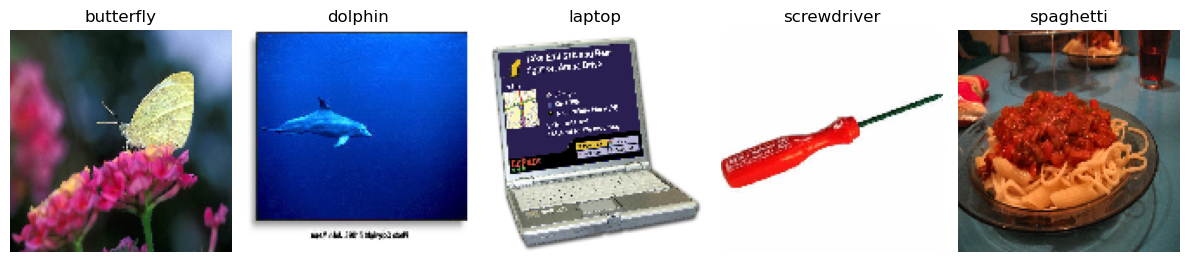

In [42]:
# Display one image for each of the 5 classes

plt.figure(figsize=(12, 6))
shown = set()

# Loop through all images
for i in range(len(X)): 
    label = y[i]
    class_name = class_names[label]
    
    # But only show one image per class
    if class_name not in shown:
        plt.subplot(1, len(class_names), len(shown) + 1)
        plt.imshow(X[i])
        plt.title(class_name)
        plt.axis('off')
        shown.add(class_name)
    
    if len(shown) == len(class_names): # We have shown all classes
        break


plt.tight_layout()
plt.show()

# 3. Dataset Splitting

We now divide the dataset into two sets:
- A **training set** (90%) on which to train the neural network
- A **test set** (10%) to evaluate its performance

The split occurs in a stratified manner, to ensure that each class is represented proportionally in both sets.

In [43]:
# 3. Split into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=seed
)


print("Train set:", X_train.shape, y_train.shape)
print("Test set :", X_test.shape, y_test.shape)

Train set: (450, 128, 128, 3) (450,)
Test set : (50, 128, 128, 3) (50,)


# 4. Building and Training the Convolutional Neural Network (CNN)

In this phase we build a convolutional neural network (CNN).

The network will be trained **only on original images** (not degraded), and will serve as a reference point to later compare performance on quantized images and with dithering.

The architecture adopted is as follows:

- **3 convolutional layers** with ReLU activation function, each followed by **max pooling**
- 1 **fully-connected** (dense) layer with ReLU activation
- A **dropout** layer to reduce overfitting
- An **output layer** with softmax activation to classify images into different categories

In [44]:
# 4. Building the CNN model

from tensorflow.keras.layers import Input

input_shape = (128, 128, 3)  # Input image size: 128x128 pixels with 3 channels (RGB)


model = Sequential([                                                # Creation of the sequential model 
    
    Input(shape=input_shape),                                       # Input layer defining the shape of input images
    
    Conv2D(32, (3, 3), activation='relu'),                          # First convolutional layer with 32 filters, 3x3 kernel and ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),                                 # Pooling layer to reduce spatial dimension


    Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters, 3x3 kernel and ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),         # Pooling layer to reduce spatial dimension


    Conv2D(128, (3, 3), activation='relu'), # Third convolutional layer with 128 filters, 3x3 kernel and ReLU activation function
    MaxPooling2D(pool_size=(2, 2)),         # Pooling layer to reduce spatial dimension


    Flatten(),                                      # Flattening the 3D matrix into a 1D vector for input to the dense layer
    
    Dense(128, activation='relu'),                  # Dense layer with 128 neurons and ReLU activation function
    
    Dropout(0.5),                                   # Dropout to prevent overfitting, randomly disabling 50% of neurons during training
    
    Dense(len(np.unique(y)), activation='softmax')  # Output layer with one neuron per class. Returns a probability for each class using the softmax activation function
])


model.compile(
    optimizer=Adam(learning_rate=0.001),    # Adam optimizer with a learning rate of 0.001
    loss='sparse_categorical_crossentropy', # Loss function for multiclass classification
    metrics=['accuracy']                    # Metrics to monitor during model training and evaluation
)


model.summary() # Shows a summary of the model structure

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,285 (12.61 MB)

 Trainable params: 3,305,285 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

## 4.1 Model Training

We now train the convolutional neural network (CNN) using the training set composed of original images.

Training will be monitored on a small validation set (automatically derived from the training set), and we will use the **accuracy** metric to evaluate the model's performance.

To reduce the risk of overfitting, we also apply an **early stopping** strategy, which interrupts training when validation performance stops improving.

In [45]:
# 4.1 Model training

early_stop = EarlyStopping(patience=5, restore_best_weights=True) # Stops training if there are no improvements for 5 epochs


# history contains information about model training, such as loss and accuracy for each epoch
history = model.fit(
    X_train, y_train,
    validation_split=0.1,  # 10% of training set for validation
    epochs=50,
    batch_size=8,
    callbacks=[early_stop]
)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3235 - loss: 1.4543 - val_accuracy: 0.4667 - val_loss: 1.4603
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.3235 - loss: 1.4543 - val_accuracy: 0.4667 - val_loss: 1.4603
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4667 - loss: 1.2543 - val_accuracy: 0.6667 - val_loss: 1.3984
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.4667 - loss: 1.2543 - val_accuracy: 0.6667 - val_loss: 1.3984
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5531 - loss: 1.1644 - val_accuracy: 0.6667 - val_loss: 1.2887
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.5531 - loss: 1.1644 - val_accuracy: 0.6667 - val_loss: 1.2887
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5802 - loss: 1.1118 - val_accuracy: 0.6889 - val_loss: 1.2886
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.5802 - loss: 1.1118 - val_accuracy: 0.6889 - v

# 5. Model Evaluation on Original Test Set

After completing the training of the neural network, we proceed with evaluating the model on the **original test set**, which contains non-degraded images.

This evaluation will provide us with a **reference benchmark**: the accuracy obtained on "clean" images will serve to later compare the model's performance on **quantized** and **dithered** images.

We will measure performance through **accuracy**, i.e., the percentage of correctly classified images in the test set.

In [46]:
# 5. Model evaluation on original test set

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)    # Evaluate the model on the test set

print(f"\nAccuracy on original test set: {test_accuracy:.4f}")        # Print the model's accuracy on the original test set

2/2 - 0s - 63ms/step - accuracy: 0.7000 - loss: 0.8498

Accuracy on original test set: 0.7000

Accuracy on original test set: 0.7000


# 6. Quantization and Dithering of Test Set Images

In this phase we apply various transformations to the **test set** images.

Working now on **color images**, the quantization and dithering transformations will be applied **separately on each channel** (R, G, B).

The techniques we will consider are:

1. **Uniform quantization** at 2 bits per channel: direct reduction of levels for each channel.
2. **Random Dithering**: adding random noise to channels before quantization.
3. **Ordered Dithering**: using a Bayer matrix replicated for each channel to introduce a regular pattern.
4. **Error Diffusion (Floyd–Steinberg)**: propagation of quantization error to neighboring pixels separately on R, G, and B.

For each image, we will show the visual results of the transformations to understand how each technique affects the appearance of the image.

Finally, we will test our classifier's performance also on these degraded images, to evaluate the actual impact on classification.

In [47]:
# Uniform quantization function
def quantize(img, n_bits=2):
    levels = 2 ** n_bits                                            # Calculate the number of levels
    img_norm = img / 255.0                                          # Normalize to [0, 1]
    
    quantized = np.floor(img_norm * (levels - 1)) / (levels - 1)    # Quantize the image
                                                                    # map values from [0, 1] to [0, levels-1]
                                                                    # truncate values to discrete levels
                                                                    # and divide by (levels - 1) to return to [0, 1]
                                                                    
    return (quantized * 255).astype(np.uint8)                       # Return to [0, 255] 



# Random dithering
def dither_random(img, n_bits=2):
    levels = 2 ** n_bits                                                # Calculate the number of levels
    img_norm = img / 255.0                                              # Normalize to [0, 1]
    
    noise = np.random.uniform(-0.5/levels, 0.5/levels, img.shape)       # Creation of random noise.
                                                                        # noise is an array of the same size as the image with random values between -0.5/levels and 0.5/levels
    noisy = img_norm + noise                                            # Add the noise
    
    noisy = np.clip(noisy, 0, 1)                                        # Limit values to [0, 1] 
    
    quantized = np.floor(noisy * (levels - 1)) / (levels - 1)           # Quantize the image (as above)
    return (quantized * 255).astype(np.uint8)                           # Return to [0, 255]



# Bayer matrix construction (Ordered Dithering)
def bayer_matrix(n):
    if n == 2:
        return np.array([[0, 2],
                         [3, 1]])
        
    smaller = bayer_matrix(n//2) # Recursion to build the smaller Bayer matrix
    
    # returns the Bayer matrix of size n x n
    return np.block([[4*smaller, 4*smaller + 2],
                     [4*smaller + 3, 4*smaller + 1]])


def dither_ordered(img, n_bits=2, matrix_size=4):
    levels = 2 ** n_bits                                                                    # Calculate the number of levels
    img_norm = img / 255.0                                                                  # Normalize to [0, 1]
    
    M = bayer_matrix(matrix_size)                                                           # Build the Bayer matrix
    M = (M + 0.5) / (matrix_size ** 2)                                                      # and normalize it
    
    threshold = np.tile(M, (img.shape[0] // matrix_size + 1, img.shape[1] // matrix_size + 1))  # Replicate the matrix over the entire image
    threshold = threshold[:img.shape[0], :img.shape[1]]                                         # Crop it to the image size
    
    
    # Apply to each channel separately
    result = np.zeros_like(img_norm)
    for c in range(3):  # for each channel (R, G, B)
        noisy = img_norm[..., c] + (threshold - 0.5) / levels           # Add the noise, threshold is a matrix of the same size as the image and has values between 0 and 1
        noisy = np.clip(noisy, 0, 1)                                    # Limit values to [0, 1]
        result[..., c] = np.floor(noisy * (levels - 1)) / (levels - 1)  # Quantize the image (as above)
    
    return (result * 255).astype(np.uint8)                              # Return to [0, 255]



# Error Diffusion (Floyd–Steinberg)
def dither_floyd_steinberg(img, n_bits=2):
    levels = 2 ** n_bits                                                        # Calculate the number of levels
    img_norm = img / 255.0                                                      # Normalize to [0, 1]
    
    out = img_norm.copy()                                                       # Create a copy of the image

    for y in range(img.shape[0]):                                               # Loop through rows
        for x in range(img.shape[1]):                                           # Loop through columns
            for c in range(3):                                                  # Loop through channels (R, G, B)
                
                old_pixel = out[y, x, c]                                        # Get the current pixel
                new_pixel = np.round(old_pixel * (levels - 1)) / (levels - 1)   # Quantize the pixel
                out[y, x, c] = new_pixel                                        # Update the pixel
                error = old_pixel - new_pixel                                   # Calculate the quantization error to be distributed


                # Error distribution according to the Floyd-Steinberg scheme
                if x + 1 < img.shape[1]:
                    out[y, x + 1, c] += error * 7 / 16          # pixel to the right
                if y + 1 < img.shape[0]: 
                    if x > 0:
                        out[y + 1, x - 1, c] += error * 3 / 16  # pixel bottom left
                    out[y + 1, x, c]     += error * 5 / 16      # pixel below
                    if x + 1 < img.shape[1]:
                        out[y + 1, x + 1, c] += error * 1 / 16  # pixel bottom right
    
    # End of error distribution
    
    out = np.clip(out, 0, 1)            # Limit values to [0, 1]
    return (out * 255).astype(np.uint8) # Return to [0, 255]

## 6.1 Comparative Visualization of Transformations

To better understand the visual effect of **quantization** and various **dithering** techniques, we apply all transformations to a small sample of test set images.

For each image we will show:

- The original image at 8 bits per channel
- The quantized version at 2 bits per channel (without dithering)
- The version with **random dithering**
- The version with **ordered dithering** (Bayer matrix)
- The version with **error diffusion** (Floyd–Steinberg algorithm)

This visual comparison will help us observe how dithering techniques try to preserve details despite the reduction in color depth.

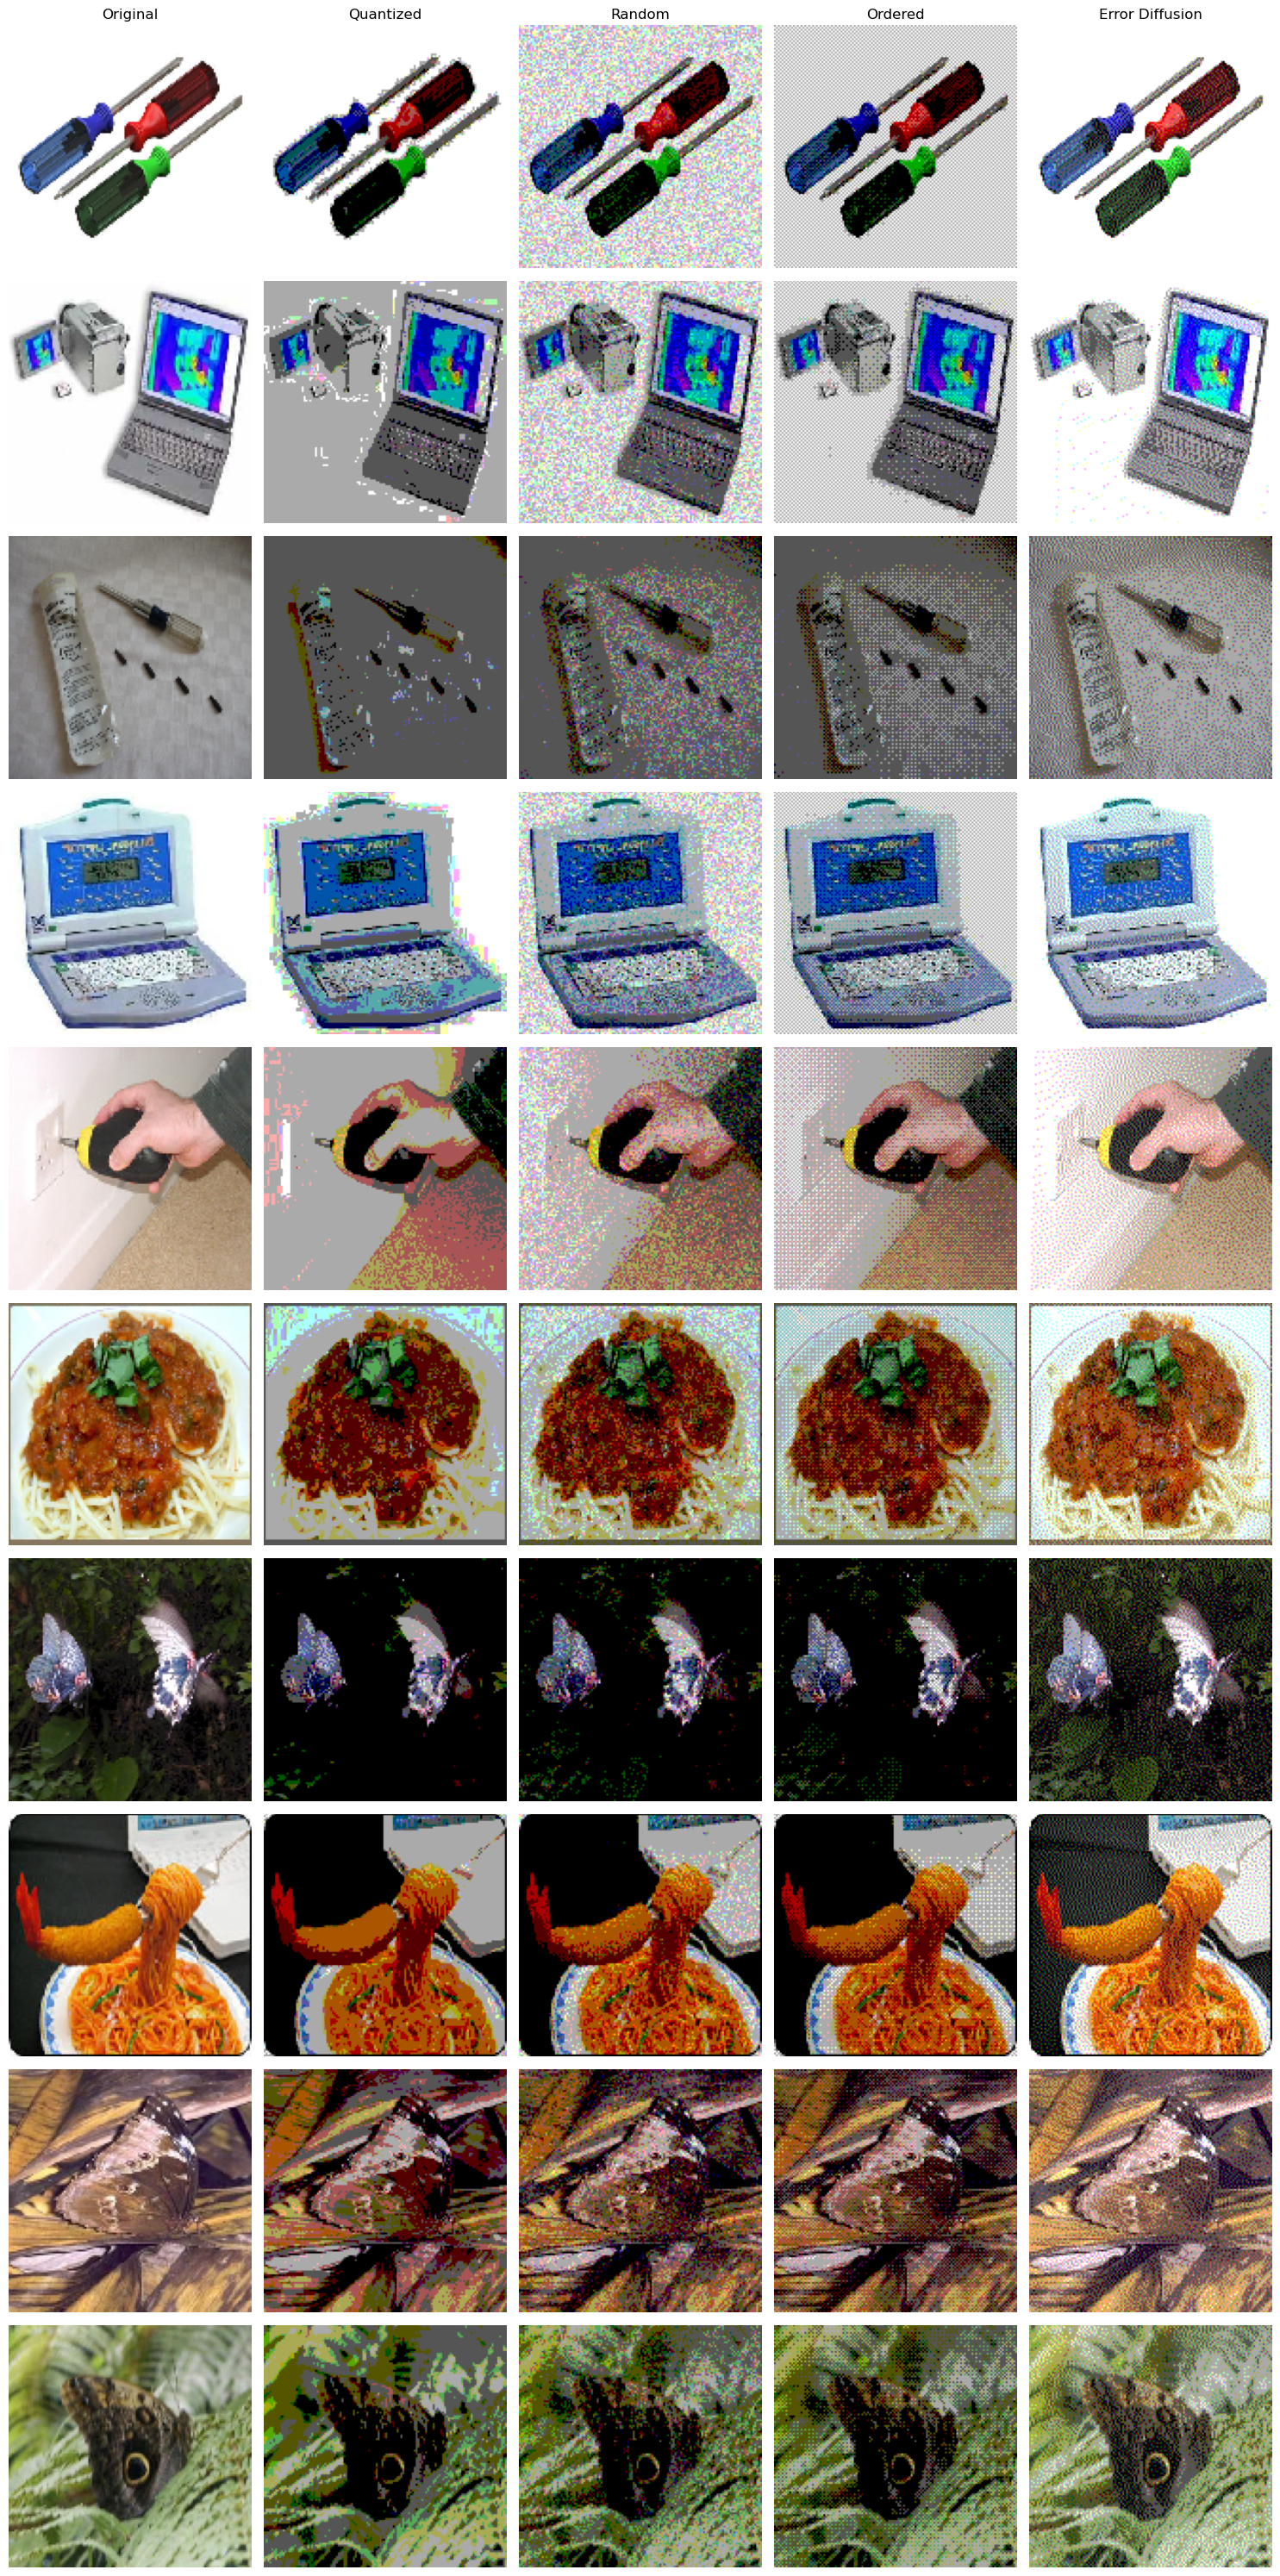

In [48]:
# Number of images to display
num_images = 10
indices = np.random.choice(len(X_test), num_images, replace=False) # Randomly select "num_images" indices

# Visualization
titles = ["Original", "Quantized", "Random", "Ordered", "Error Diffusion"]

plt.figure(figsize=(15, 3 * num_images)) # Set the figure size

for i, idx in enumerate(indices):
    original = (X_test[idx] * 255).astype(np.uint8)  # Take the image from the test set and return it to [0, 255] so I can apply quantization and dithering techniques


    # Apply quantization and dithering for each channel
    q = quantize(original, n_bits=2)
    r = dither_random(original, n_bits=2)
    o = dither_ordered(original, n_bits=2)
    f = dither_floyd_steinberg(original, n_bits=2)



    versions = [original, q, r, o, f]

    # Show the images
    for j, img in enumerate(versions):
        plt.subplot(num_images, 5, i * 5 + j + 1)
        plt.imshow(img)
        if i == 0:
            plt.title(titles[j]) # Titles only for the first row
        plt.axis('off')

plt.tight_layout()
plt.show()

## 6.2 Creation of Degraded Test Sets

After visually observing the effect of transformations, we now proceed to create the **degraded test sets**. These sets of images will be used to evaluate our model's performance on modified versions of the original images.

For each image in the test set, we will generate four new versions:

1. **Uniform quantization at 2 bits**
2. **Random Dithering + Quantization**
3. **Ordered Dithering + Quantization** (Bayer matrix)
4. **Error Diffusion + Quantization** (Floyd–Steinberg)

In [49]:
# 6.2 Creation of degraded test sets

X_test_quant = []
X_test_random = []
X_test_ordered = []
X_test_error = []

for img in X_test:
    img_uint8 = (img * 255).astype(np.uint8)  # From [0,1] to [0,255] so that quantization and dithering functions work correctly

    # Apply quantization and dithering
    q = quantize(img_uint8, n_bits=2)
    r = dither_random(img_uint8, n_bits=2)
    o = dither_ordered(img_uint8, n_bits=2)
    f = dither_floyd_steinberg(img_uint8, n_bits=2)

    # Add degraded images to respective lists after converting them to float32 and renormalizing to [0, 1]
    X_test_quant.append(q.astype(np.float32) / 255.0)
    X_test_random.append(r.astype(np.float32) / 255.0)
    X_test_ordered.append(o.astype(np.float32) / 255.0)
    X_test_error.append(f.astype(np.float32) / 255.0)


# Convert degraded test set lists to NumPy arrays
X_test_quant   = np.array(X_test_quant)
X_test_random  = np.array(X_test_random)
X_test_ordered = np.array(X_test_ordered)
X_test_error   = np.array(X_test_error)

print("All degraded test sets have been generated correctly.")

All degraded test sets have been generated correctly.


# 7. Model Evaluation on Degraded Images

In this phase we test the model, previously trained on original images, on all degraded versions of the test set.

For each version (quantized or with dithering) we will measure the **classification accuracy** and compare it with the benchmark obtained on original images.

The goal is to verify **how much and how** visual quality affects the model's ability to correctly recognize objects.

In [50]:
# Dictionary to save accuracies
accuracies = {}

# Accuracy on original images (already calculated previously)
accuracies["Original"] = test_accuracy  # test_accuracy was printed earlier

# Evaluation on each degraded set. From the evaluate function we get the accuracy
accuracies["Quantized"]     = model.evaluate(X_test_quant, y_test, verbose=0)[1]
accuracies["Random Dithering"] = model.evaluate(X_test_random, y_test, verbose=0)[1]
accuracies["Ordered Dithering"] = model.evaluate(X_test_ordered, y_test, verbose=0)[1]
accuracies["Error Diffusion"]  = model.evaluate(X_test_error, y_test, verbose=0)[1]

# Print results
for name, acc in accuracies.items():
    print(f"Accuracy on {name} images: {acc:.4f}")

Accuracy on Original images: 0.7000
Accuracy on Quantized images: 0.6200
Accuracy on Random Dithering images: 0.6600
Accuracy on Ordered Dithering images: 0.6200
Accuracy on Error Diffusion images: 0.6800


## 7.1 Graphical Visualization of Accuracies

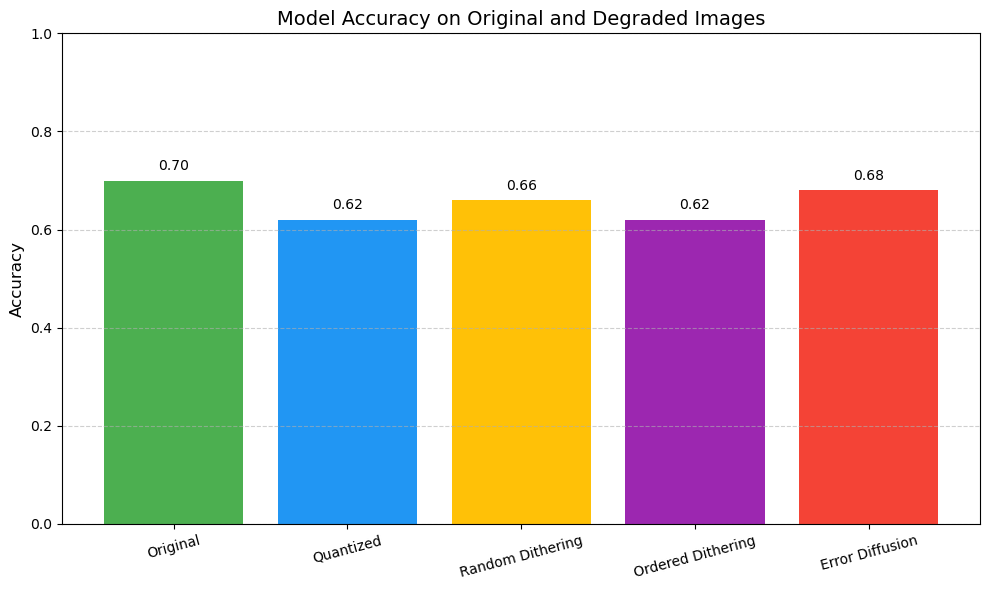

In [51]:
# Extract keys and values from the accuracies dictionary for the chart
labels = list(accuracies.keys())
values = list(accuracies.values())

# Different colors for each bar
colors = ['#4CAF50', '#2196F3', '#FFC107', '#9C27B0', '#F44336']

# Chart creation
plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=colors)

# Labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.015, f"{height:.2f}", 
             ha='center', va='bottom', fontsize=10)

# Chart customization
plt.title("Model Accuracy on Original and Degraded Images", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.0)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 7.2 Error Analysis: Confusion Matrix

To further evaluate our model, we now analyze the **confusion matrices** obtained on each degraded test set.

The **confusion matrix** is a useful tool to observe **which classes are most confused** by the model.  
Each matrix represents:

- **rows** as the actual classes
- **columns** as the predicted classes

An ideal model shows high values only on the **main diagonal**, indicating that the predicted class always corresponds to the actual one.

In our case, we will generate and visualize a normalized confusion matrix for each of the following test set versions:
- Original images
- Quantized
- Random Dithering
- Ordered Dithering
- Error Diffusion

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


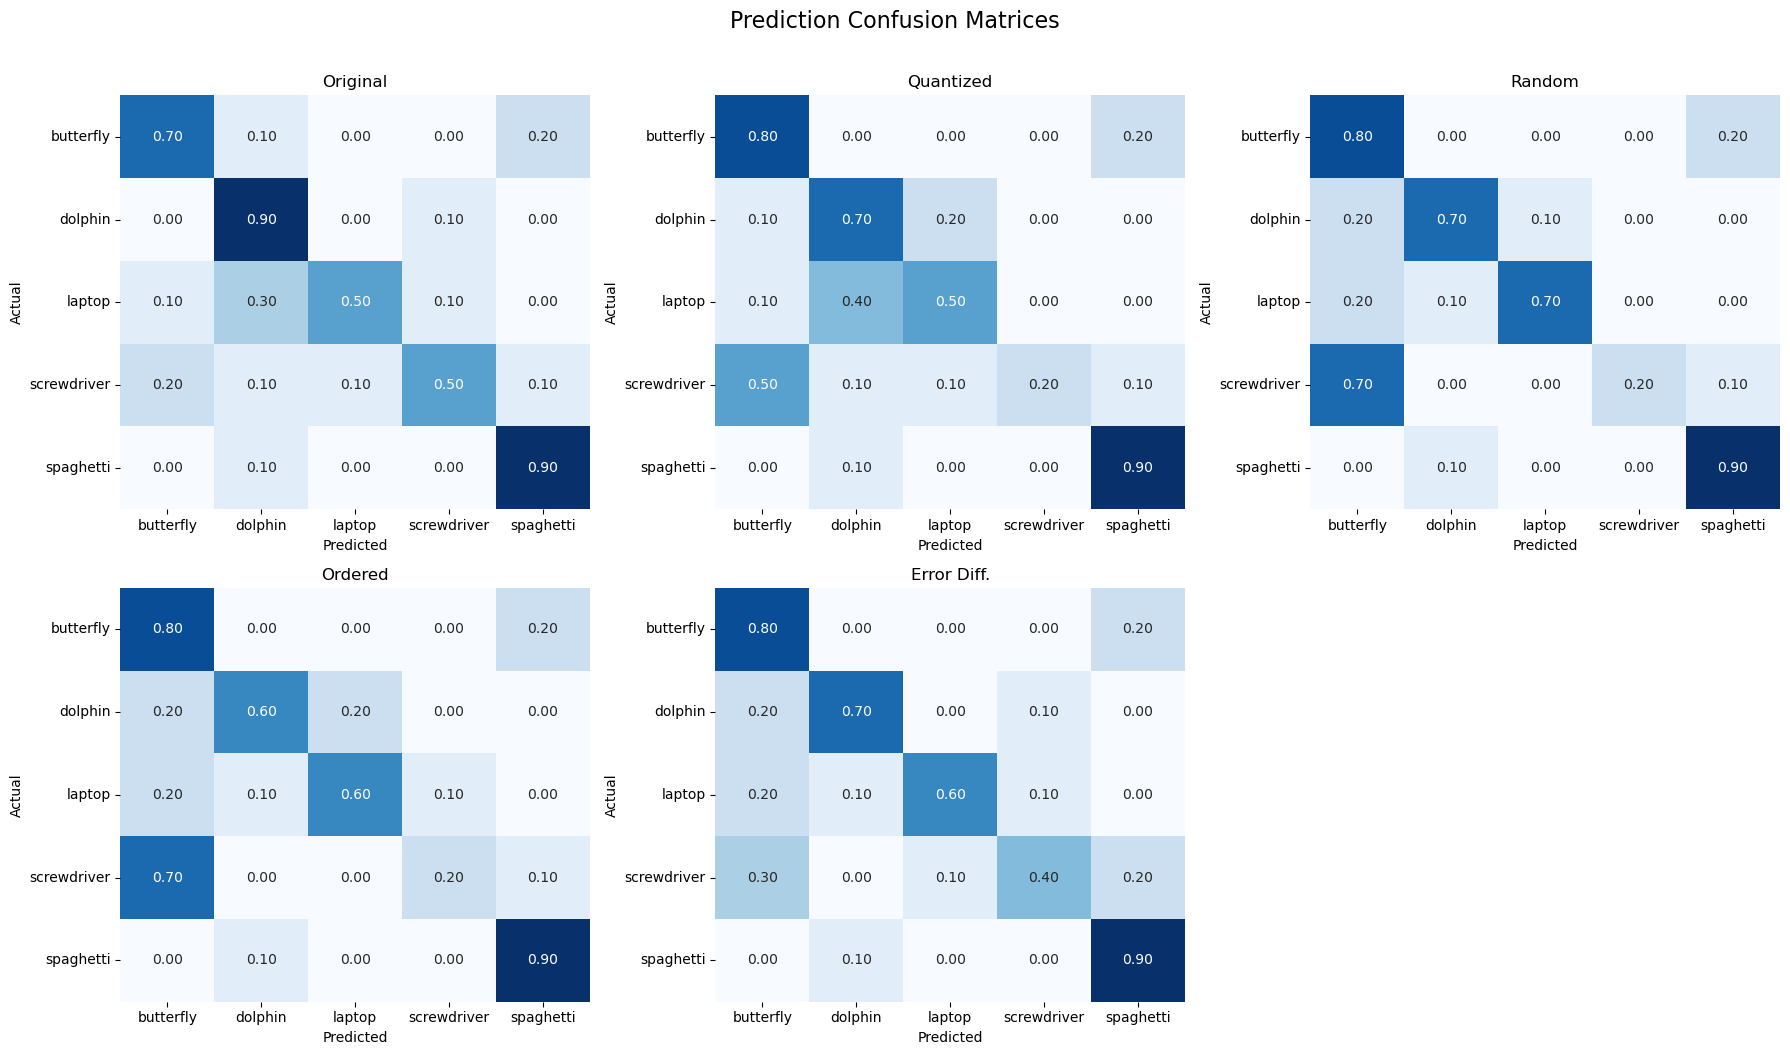

In [52]:
# Mapping of test set versions
test_sets = {
    "Original":     X_test,
    "Quantized":    X_test_quant,
    "Random":       X_test_random,
    "Ordered":      X_test_ordered,
    "Error Diff.":  X_test_error
}

# Graphics settings
plt.figure(figsize=(18, 10))

for i, (name, X_set) in enumerate(test_sets.items(), 1):
    # Get model predictions on the current test set
    y_pred = np.argmax(model.predict(X_set), axis=1)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    # Plot
    plt.subplot(2, 3, i)    
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=False,
            xticklabels=class_names, yticklabels=class_names)

    plt.title(name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.suptitle("Prediction Confusion Matrices", fontsize=16, y=1.05)
plt.show()